In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=10000) # just read first 10000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(147331, 4)

In [8]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [9]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [10]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inter_dim = 32
final_dim = 16
latent_dim = 4
input_dim = 4

In [13]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim, activation='relu')(x)
h2 = Dense(final_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim)(h2)

In [14]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [15]:
# decoder
decoder_h2 = Dense(final_dim, activation='relu')
decoder_h1 = Dense(inter_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h2_decoded = decoder_h2(z)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [16]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [17]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [18]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            68          dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
batch_size = 400
epochs = 100

In [21]:
x_train.shape

(117864, 4)

In [22]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val))

Train on 117864 samples, validate on 14733 samples
Epoch 1/100
117864/117864 [==============================] - 2s 19us/step - loss: 0.8392 - val_loss: 0.7218
Epoch 2/100
117864/117864 [==============================] - 2s 14us/step - loss: 0.6826 - val_loss: 0.6462
Epoch 3/100
117864/117864 [==============================] - 2s 13us/step - loss: 0.6402 - val_loss: 0.6350
Epoch 4/100
117864/117864 [==============================] - 2s 13us/step - loss: 0.6301 - val_loss: 0.6308
Epoch 5/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6273 - val_loss: 0.6205
Epoch 6/100
117864/117864 [==============================] - 1s 12us/step - loss: 0.6229 - val_loss: 0.6258
Epoch 7/100
117864/117864 [==============================] - 2s 14us/step - loss: 0.6219 - val_loss: 0.6195
Epoch 8/100
117864/117864 [==============================] - 2s 13us/step - loss: 0.6188 - val_loss: 0.6171
Epoch 9/100
117864/117864 [==============================] - 2s 13us/step - loss: 0.6

Epoch 76/100
117864/117864 [==============================] - 2s 13us/step - loss: 0.6028 - val_loss: 0.6038
Epoch 77/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6052 - val_loss: 0.6035
Epoch 78/100
117864/117864 [==============================] - 1s 12us/step - loss: 0.6037 - val_loss: 0.6046
Epoch 79/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6041 - val_loss: 0.6048
Epoch 80/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6032 - val_loss: 0.5988
Epoch 81/100
117864/117864 [==============================] - 1s 12us/step - loss: 0.6034 - val_loss: 0.6007
Epoch 82/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6022 - val_loss: 0.6028
Epoch 83/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6032 - val_loss: 0.6082
Epoch 84/100
117864/117864 [==============================] - 1s 13us/step - loss: 0.6040 - val_loss: 0.6038
Epoch 85/100
117864

# Visualization

In [23]:
import matplotlib.pyplot as plt

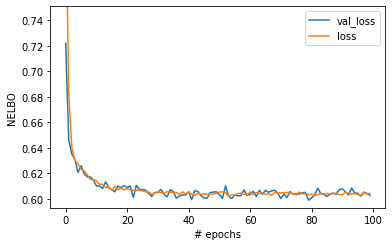

In [24]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [25]:
predictions = vae.predict(x_test)

In [26]:
predictions

array([[-0.37891942,  0.08580951,  0.79146504, -0.3143422 ],
       [-0.43712667,  1.2223823 ,  0.895479  , -0.3679811 ],
       [ 2.2418325 ,  0.01471937, -0.62820506,  0.88030183],
       ...,
       [-0.37510985, -0.25676107,  0.8434301 , -0.3079686 ],
       [-0.4386793 ,  1.1532992 , -0.91081923, -0.3496287 ],
       [-0.37992996,  0.8270169 ,  0.52565366, -0.2980941 ]],
      dtype=float32)

In [27]:
distr = (x_test - predictions) / x_test

In [28]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [29]:
pT = [row[0] for row in x_test]
eta = [row[1] for row in x_test]
phi = [row[2] for row in x_test]
mass = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        1.300e+01, 1.000e+01, 5.300e+01, 3.810e+02, 5.480e+02, 5.080e+02,
        4.300e+02, 5.110e+02, 8.630e+02, 1.251e+03, 1.419e+03, 1.454e+03,
        1.366e+03, 1.385e+03, 8.770e+02, 3.780e+02, 1.750e+02, 1.250e+02,
        9.100e+01, 7.700e+01, 7.200e+01, 6.000e+01, 3.200e+01, 3.900e+01,
        3.000e+01, 2.800e+01, 2.500e+01, 1.500e+01, 2.400e+01, 2.000e+01,
        1.800e+01, 1.000e+01, 1.300e+01, 9.000e+00, 1.300e+01, 6.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 4.000e+00,
        2.000e+00]),
 array([-0.5       , -0.49387755, -0.4877551 , -0.48163265, -0.4755102 ,
        -0.46938776, -0.46326531, -0.45714286, -0.45102041, -0.44489796,
        -0.43877551, -0.43265306, -0.42653061, -0.42040816, -0.41428571,
        -0.40816327, -0.40204082, -0.39591837, -0.38979592, -0.38367347,
        -0.37755102, -0.37142857, -0.36530612, -0.35918367, -0.35306122,
        -0.34693878, -

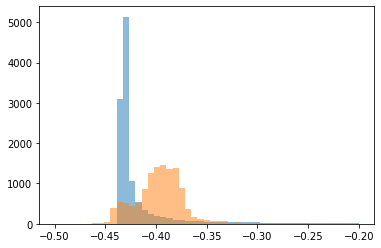

In [49]:
bins = np.linspace(-0.5, -0.2, 50)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  11.,  18.,
         40.,  65., 102., 163., 256., 299., 314., 280., 289., 302., 308.,
        302., 328., 276., 207., 206., 217., 220., 234., 196., 225., 195.,
        214., 202., 200., 241., 372., 580., 983., 721., 273., 184., 220.,
        202., 194., 188., 210., 182., 196., 216., 192., 199., 221., 242.,
        306., 313., 347., 301., 268., 282., 289., 332., 279., 222., 168.,
         82.,  38.,  17.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.]),
 array([-2.        , -1.94936709, -1.89873418, -1.84810127, -1.79746835,
        -1.74683544, -1.69620253, -1.64556962, -1.59493671, -1.5443038 ,
        -1.49367089, -1.44303797, -1.39240506, -1.34177215, -1.29113924,
        -1.24050633, -1.18987342, -1.13924051, -1.08860759, -1.03797468,
        -0.98734177, -0.93670886, -0.88607595, -0.83544304, -0.78481013,
        -0.73417722, -0.6835443 , -0.63291139, -0.58227848, -0.53164557,
        -0.48101266, -

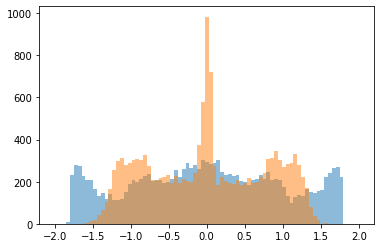

In [42]:
bins = np.linspace(-2, 2, 80)
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          2.,   2.,   2.,   3.,  19.,  14.,  34.,  47.,  64., 115., 177.,
        241., 302., 365., 396., 308., 251., 266., 270., 294., 309., 284.,
        269., 260., 214., 201., 202., 191., 195., 207., 212., 210., 222.,
        208., 190., 217., 247., 221., 223., 219., 222., 227., 218., 223.,
        202., 221., 198., 202., 216., 204., 212., 201., 198., 206., 212.,
        222., 196., 303., 406., 455., 431., 372., 348., 283., 259., 210.,
        141., 102.,  72.,  47.,  28.,  13.,   7.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-2.        , -1.95959596, -1.91919192, -1.87878788, -1.83838384,
        -1.7979798 , -1.75757576, -1.71717172, -1.67676768, -1.63636364,
        -1.5959596 , -1.55555556, -1.51515152, -1.47474747, -1.43434343,
        -1.39393939, -1.35353535, -1.31313131, -1.27272727, -1.23232323,
        -1.19191919, -1.15151515, -1.111

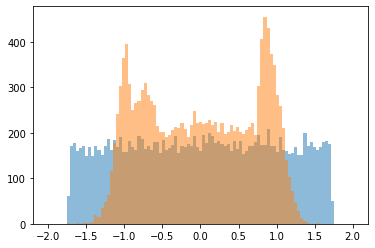

In [41]:
bins = np.linspace(-2,2, 100)
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

(array([3.600e+01, 1.161e+03, 4.176e+03, 5.540e+03, 1.045e+03, 2.400e+02,
        1.130e+02, 4.300e+01, 1.900e+01, 1.300e+01, 2.300e+01, 2.600e+01,
        1.400e+01, 1.100e+01, 1.000e+01, 1.300e+01, 1.300e+01, 8.000e+00,
        1.300e+01, 1.300e+01, 5.000e+00, 1.100e+01, 9.000e+00, 5.000e+00,
        9.000e+00, 1.300e+01, 6.000e+00, 9.000e+00, 1.000e+01, 1.400e+01,
        1.500e+01, 1.600e+01, 1.600e+01, 1.300e+01, 1.900e+01, 2.200e+01,
        2.900e+01, 3.700e+01, 3.000e+01, 3.000e+01, 2.300e+01, 2.600e+01,
        3.100e+01, 2.800e+01, 3.500e+01, 2.700e+01, 3.200e+01, 4.200e+01,
        2.800e+01, 2.300e+01, 4.100e+01, 2.300e+01, 3.000e+01, 3.500e+01,
        4.100e+01, 3.600e+01, 2.900e+01, 2.100e+01, 3.000e+01]),
 array([-0.4       , -0.37627119, -0.35254237, -0.32881356, -0.30508475,
        -0.28135593, -0.25762712, -0.23389831, -0.21016949, -0.18644068,
        -0.16271186, -0.13898305, -0.11525424, -0.09152542, -0.06779661,
        -0.0440678 , -0.02033898,  0.00338983,  0.

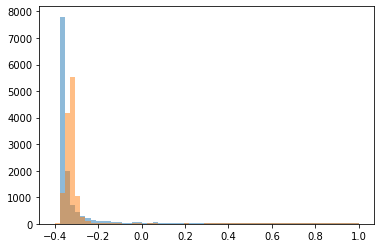

In [33]:
bins = np.linspace(-.4,1, 60)
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [34]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

In [50]:
bins = np.linspace(-2, 2, 30)

(array([  15.,   10.,   17.,   20.,   21.,   21.,   29.,   47.,   61.,
          60.,  103.,  173.,  274.,  706., 5645., 6005.,  523.,  169.,
          39.,   42.,   29.,   16.,   21.,   21.,   43.,   40.,   35.,
          31.,   19.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

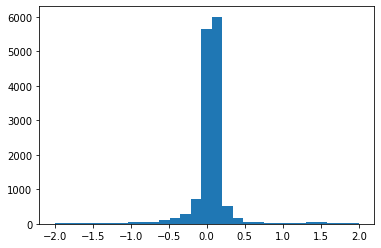

In [51]:
plt.hist(d_pT, bins=bins)

(array([  53.,   51.,   47.,   46.,   78.,  100.,  113.,  143.,  169.,
         202.,  260.,  327.,  460.,  519.,  685., 1165., 1684., 1416.,
        1000.,  774.,  783.,  897.,  663.,  423.,  240.,  182.,  161.,
         120.,  104.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

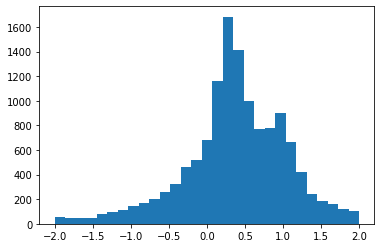

In [52]:
plt.hist(d_eta, bins=bins)

(array([  42.,   51.,   64.,   79.,   68.,   97.,  105.,  136.,  157.,
         222.,  254.,  341.,  415.,  522.,  789., 1085., 1656., 1747.,
        1126.,  830.,  696.,  561.,  400.,  279.,  246.,  168.,  145.,
         136.,  115.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

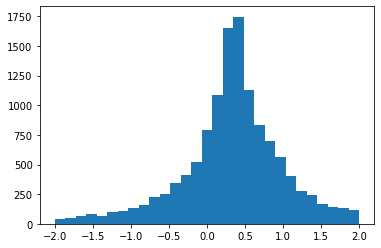

In [53]:
plt.hist(d_phi, bins=bins)